In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
hla_mel = pd.read_csv("./data/HLA_Mel.csv")
hla_mel = hla_mel[hla_mel['Experiment'].apply(lambda x: x.endswith("HLA-II"))]


In [6]:
naming_map = {
    hla_mel.iloc[row]['Raw file'] : hla_mel.iloc[row]['Experiment']
    for row in range(len(hla_mel))
}

In [3]:
set_threshold = 0.1
prosit_peptides = f"/data/yejb/prosit/figs/boosting/figs/Figure_5_HLA_2/forPride/rescoring_for_paper_2/Mels/"
ft_peptides = f"/data/yejb/prosit/figs/boosting/figs/Figure_5_HLA_2/percolator_hdf5_Mels_{set_threshold}"

# prosit_peptides = pd.read_csv(
#     "/data/yejb/prosit/figs/boosting/figs/Figure_5_HLA_1/percolator/prosit_hcd_finetune/no_finetuned_all/prosit_best_target.psms", sep='\t')
# ft_peptides = pd.read_csv(
#     "/data/yejb/prosit/figs/boosting/figs/Figure_5_HLA_1/percolator/prosit_hcd_finetune/finetuned_twofold/prosit_best_target.psms", sep='\t')


In [7]:
def read_mel(pep_dirs, threshold=0.01, add_dir=None):
    from collections import defaultdict
    all_mels = defaultdict(list)
    mels = set([v for _, v in naming_map.items()])
    for melname in mels:
        if not add_dir:
            pep_path = os.path.join(pep_dirs, f"{melname}/prosit_target.peptides")
        else:
            pep_path = os.path.join(pep_dirs, f"{melname}/percolator/prosit_target.peptides")
        df = pd.read_csv(pep_path, sep='\t')
        f_p_peptides = df[df['q-value'] < threshold]['peptide'].apply(
            lambda x: x.strip("_").strip(".")).unique()
        all_mels[melname].extend(f_p_peptides)
    for name in all_mels.keys():
        all_mels[name] = set(all_mels[name])
    return all_mels


In [9]:
threshold = 0.01
prosit_mels = read_mel(prosit_peptides, threshold=threshold, add_dir="C")
ft_mels = read_mel(ft_peptides, threshold=threshold)

all_lsg = []
for melname in ft_mels.keys():
    p_p = prosit_mels[melname]
    f_p = ft_mels[melname]
    lost = (p_p - f_p)
    share = p_p.intersection(f_p)
    gain = (f_p - p_p)
    all_lsg.append((melname, (len(lost), len(share), len(gain))))

In [10]:
print(sum([len(v) for v in prosit_mels.values()]))
print(sum([len(v) for v in ft_mels.values()]))

40097
41984


In [12]:
print(len(ft_mels['Mel-15_HLA-II']))
len(prosit_mels['Mel-15_HLA-II'])


9241


8893

In [17]:
def plot_alleles_lsg(all_lsg):
    all_lsg = sorted(all_lsg, key=lambda x: (
        x[1][1] + x[1][2]) / (x[1][1] + x[1][0] + 1e-9))
    c_loss = 'orange'
    c_shared = 'darkslateblue'
    c_gain = 'green'
    linewidth = 0.5
    barwidth = 0.9
    fig, ax = plt.subplots(figsize=(9, 6), dpi=200)

    alleles = [x[0].split("_")[0] for x in all_lsg]
    norm_sum = np.array([x[1][0]+x[1][1] for x in all_lsg]) + 1e-9
    losses = np.array([-x[1][0] for x in all_lsg])/norm_sum * 100
    shares = np.array([x[1][1] for x in all_lsg])/norm_sum * 100
    gains = np.array([x[1][2] for x in all_lsg])/norm_sum * 100
    x_ticks = list(range(len(alleles)))
    p1 = ax.bar(alleles, losses, barwidth, label="Loss",
                color=c_loss, linewidth=linewidth, edgecolor='black')
    p2 = ax.bar(alleles, shares, barwidth, label="Shared",
                color=c_shared, linewidth=linewidth, edgecolor='black')
    p3 = ax.bar(alleles, gains, barwidth, label="Gain", bottom=shares,
                color=c_gain, linewidth=linewidth, edgecolor='black')
    # for i, allele in enumerate(alleles):
    #     ax.text(i-0.2, 40000, str(gains[i]), rotation=90, va='center')
    #     ax.text(i-0.2, 20000, str(shares[i]), rotation=90, va='center')
    #     ax.text(i - 0.2, -3000, str(abs(losses[i])), rotation=90, va='center')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.axes.get_xaxis().set_visible(False)
    return fig, ax


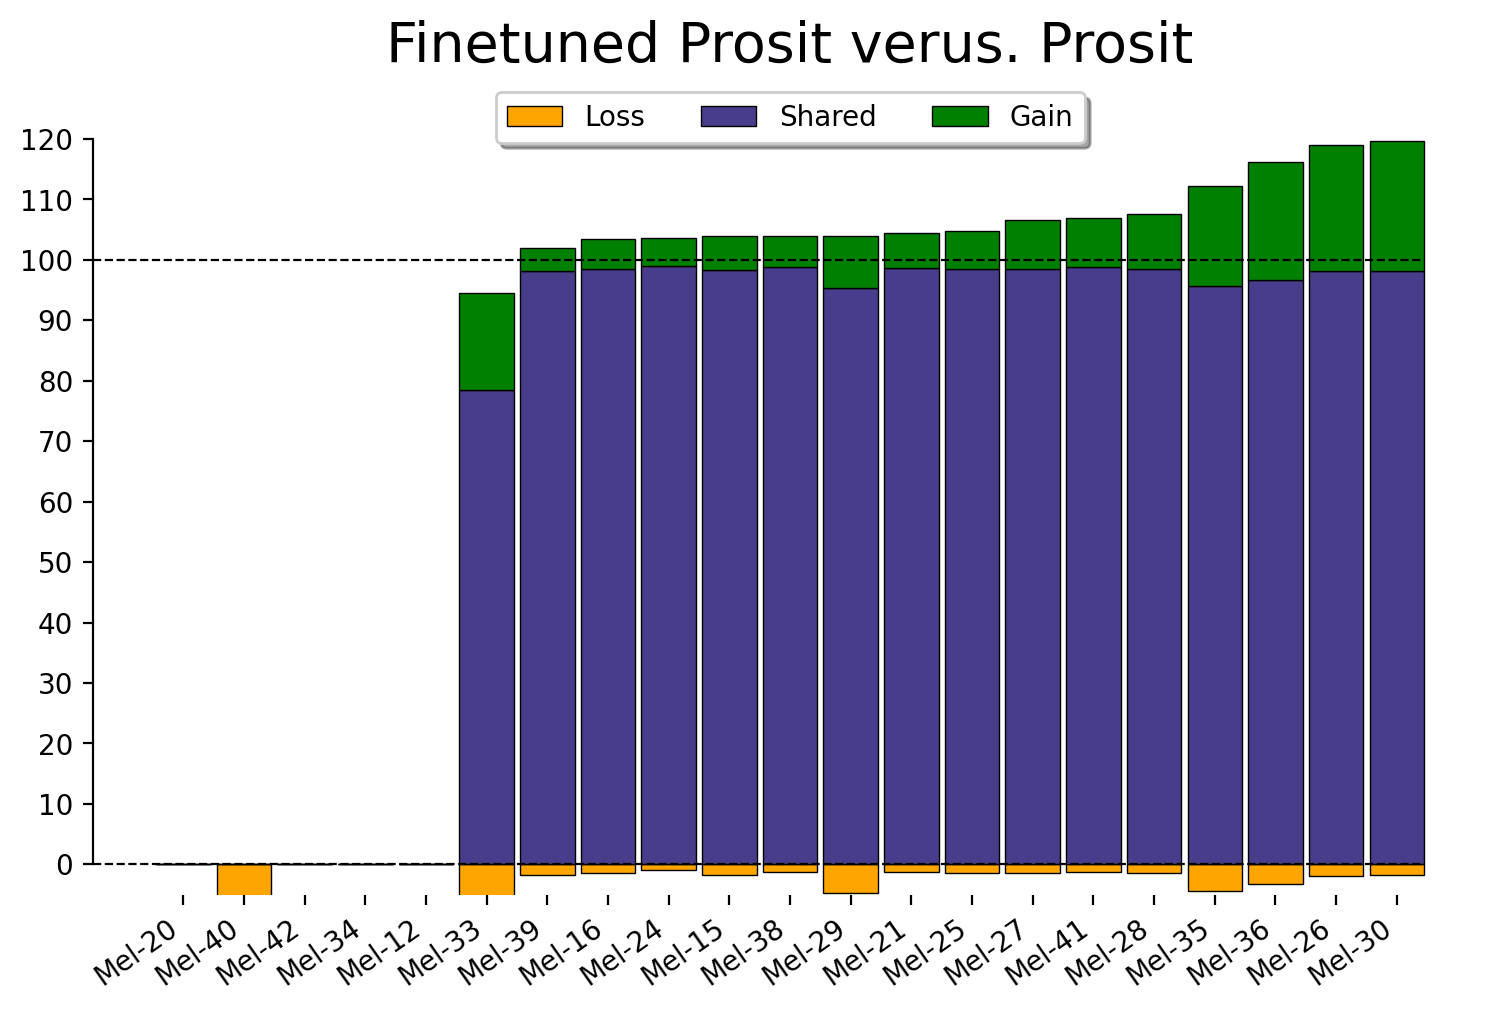

In [18]:
fig, ax = plot_alleles_lsg(all_lsg)
ax.set_title("Finetuned Prosit verus. Prosit", fontsize=20)
ax.legend(loc='upper center',
          fancybox=True, shadow=True, ncol=5)
ax.set_ylim([-5, 130])
ax.set_yticks([i*10 for i in range(13)])
ax.spines['left'].set_bounds(0, 120)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--', xmin=0, xmax=0.955)
ax.axhline(100, color='black', linewidth=0.8,
           linestyle='--', xmin=0, xmax=0.955)
fig.autofmt_xdate(rotation=35)
